In [1]:
# import os
import numpy as np
import json
import re
import matplotlib.pyplot as plt

import perceval as pcvl
import torchvision.transforms as transforms

from torch.utils.data import RandomSampler
import torch

from numpy.random import default_rng

import sys; sys.path.insert(0, '..')
from models.qgan import QGAN
from helpers.data.digits import DigitsDataset
from torchvision.transforms.functional import pil_to_tensor

from PIL import ImageEnhance, Image

In [2]:
path = "./backup/ideal/"

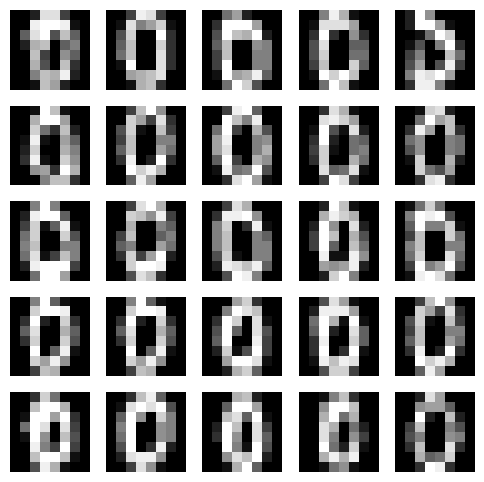

In [3]:
dataset = DigitsDataset(
    csv_file="../helpers/data/optdigits_csv.csv",
    label=0,
    transform=transforms.Compose([transforms.ToTensor()]),
)
sampler = RandomSampler(dataset, replacement=True, num_samples=25)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, drop_last=True, sampler=sampler
)

ax = plt.figure(figsize=(6, 6))
for index, image in enumerate(iter(dataloader)):
    plt.subplot(5, 5, index +   1)
    plt.imshow(image[0][0][0], cmap="gray")
    plt.axis("off")

In [4]:
def get_archstring(arch):
    return "".join([re.sub(r'[0-9]|\]|\[', '', s) for s in arch.copy()])

architectures = [
        ["var", "enc[2]", "var"],
        ["var", "var", "enc[2]", "var", "var"],
        ["var", "enc[1]", "var", "enc[3]", "var"],
        ["var", "var", "enc[1]", "var", "var", "enc[3]", "var", "var"],
        ["var", "enc[0]", "var", "enc[2]", "var", "enc[4]", "var"],
        ["var", "enc[1]", "var", "enc[3]", "var", "enc[5]", "var", "enc[7]", "var"],
]
archstrings = [get_archstring(s) for s in architectures]


In [5]:
def plot_loss(loss_runs, ax):
    D_loss_runs = loss_runs[:, :, 0] / 2
    G_loss_runs = loss_runs[:, :, 1]

    D_mean = np.mean(D_loss_runs, axis=0)
    D_std = np.std(D_loss_runs, axis=0)

    G_mean = np.mean(G_loss_runs, axis=0)
    G_std = np.std(G_loss_runs, axis=0)

    x = np.arange(len(D_mean))
    ax.plot(x, D_mean, "#ea9367", label="D Loss")
    ax.fill_between(x, D_mean - D_std, D_mean + D_std, color="#ea9367", alpha=0.2)

    x = np.arange(len(G_mean))
    ax.plot(x, G_mean, "#6ab5db", label="G Loss", )
    ax.fill_between(x, G_mean - G_std, G_mean + G_std, color="#6ab5db", alpha=0.2)
    ax.set_xticks(np.arange(0, len(D_mean) + 1, len(D_mean) / 10))

    ax.tick_params(axis='both', labelsize=12)
    ax.legend(loc = "lower left", fontsize = 12)
    
    ax.set_xlabel("Iteration", labelpad=-32, fontsize=14)
    ax.set_ylabel("Loss Value", fontsize=14)
    ax.set_title("Loss Evolution", loc="left", fontsize=16)


In [6]:
def plot_progress(fake_runs, axes):
    fake_mean = np.array([fake_runs[:, i::4, :] for i in range(4)]).mean(axis = 0).mean(axis = 0)
    
    ax_index = 0
    for i, data in enumerate(fake_mean):
        if i > 0 and i%20 == 0:
            ax = axes[ax_index]
            img = Image.fromarray(data.reshape(8, 8) * 255).convert('L')
            new_image = ImageEnhance.Contrast(img).enhance(1.5)
            
            ax.imshow(new_image, cmap="gray")
            ax.axis('off')
            ax.set_title("Iter " + str(i * (1500 // 100)), y=1.01, fontdict = {"fontsize": 14})
            ax_index += 1

    plt.text(x = -39, y = -8, s = "Image Evolution", fontdict = {"fontsize": 16})

In [7]:
def plot_results(params_runs, config, axes, best_run=None):
    final_results = []
    num_results = len(axes)

    qgan = QGAN(
        8,
        config["gen_count"],
        config["arch"],
        pcvl.BasicState(config["input_state"]),
        config["noise_dim"],
        4,
        config["pnr"],
        lossy=False
    )

    for params in params_runs:
        qgan.G.update_var_params(params[-1])
        final_results.append(
            qgan.G.generate(
                np.random.normal(0, 2 * np.pi, (num_results, config["noise_dim"]))
            ).numpy()
        )

    rng = default_rng()
    ss_rate = 6 if config["noise_dim"] == 1 else 5 if config["noise_dim"] == 2 else 4
    final_results = np.swapaxes(final_results, 0, 1)

    for i, data in enumerate(np.array(final_results)):
        numbers = rng.choice(10, size=ss_rate, replace=False)
        if best_run is not None:
            image = data[best_run, :]
        else:
            image = data[numbers, :].mean(axis=0)

        img = Image.fromarray(image * 255).convert('L')
        new_image = ImageEnhance.Contrast(img).enhance(1.5)

        ax = axes[i]
        ax.imshow(np.asarray(new_image).reshape(8, 8), cmap="gray")
        ax.axis("off")

    plt.text(x=-39, y=9.7, s="Generated Images", fontdict={"fontsize": 16})



varencvar


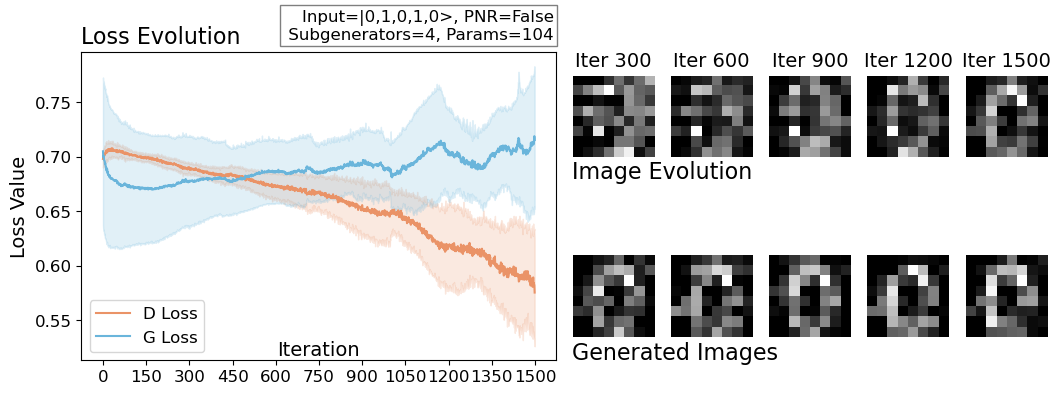

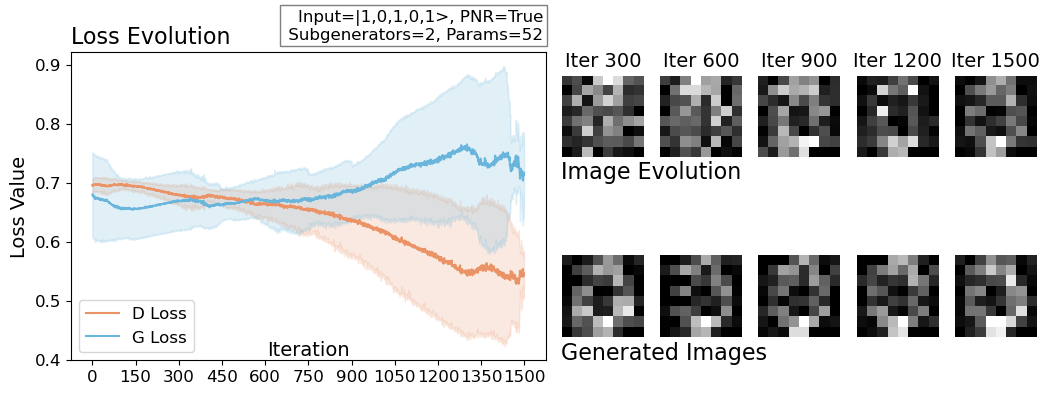

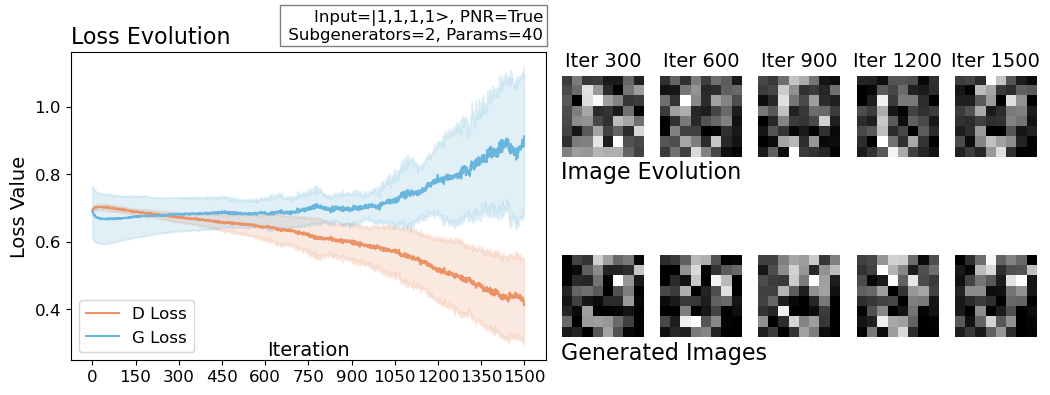

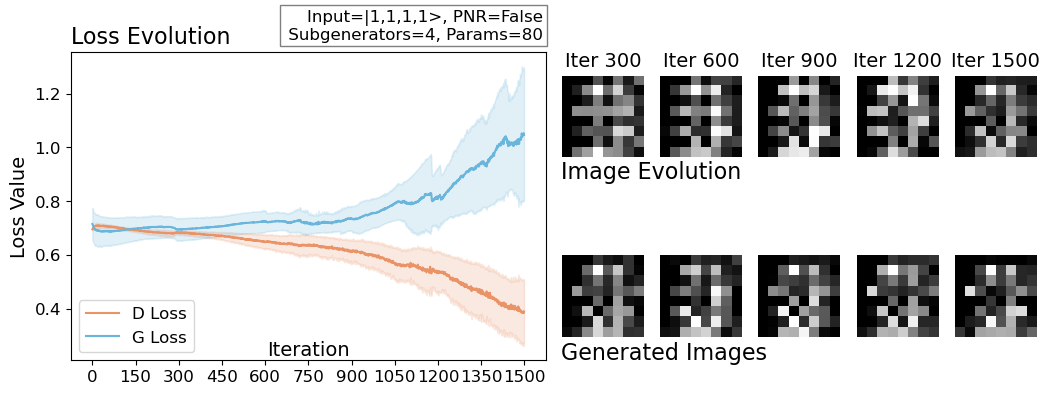

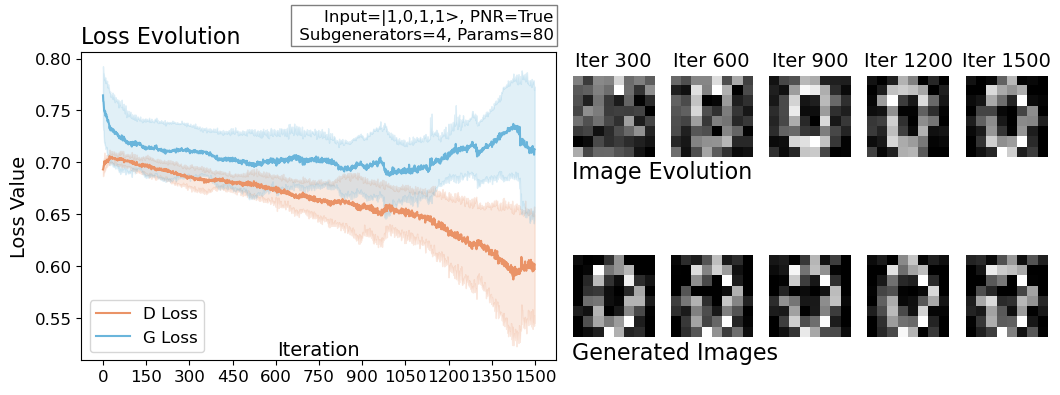

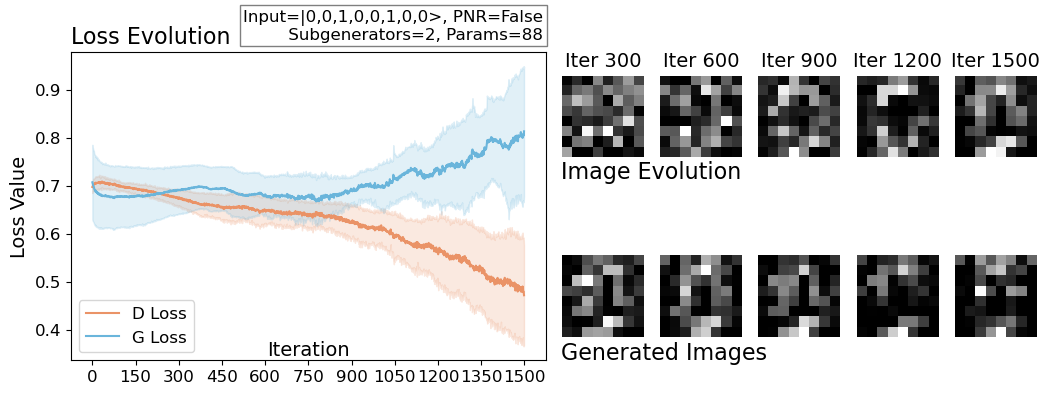

varvarencvarvar


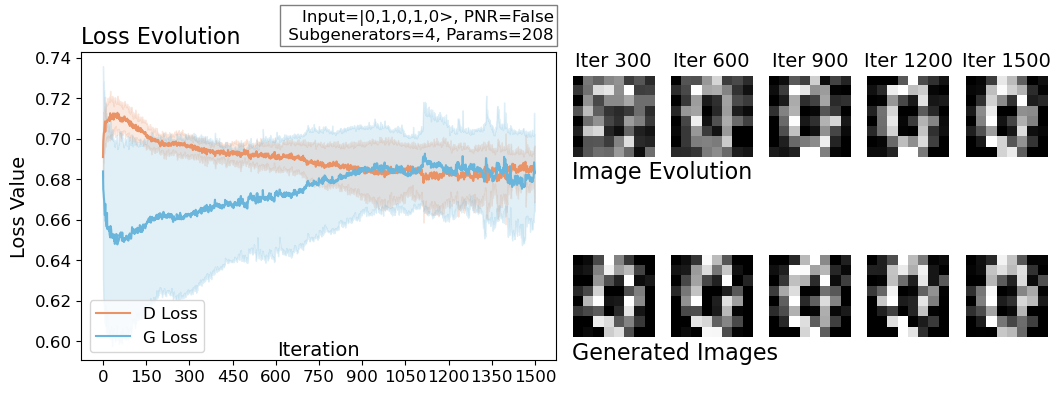

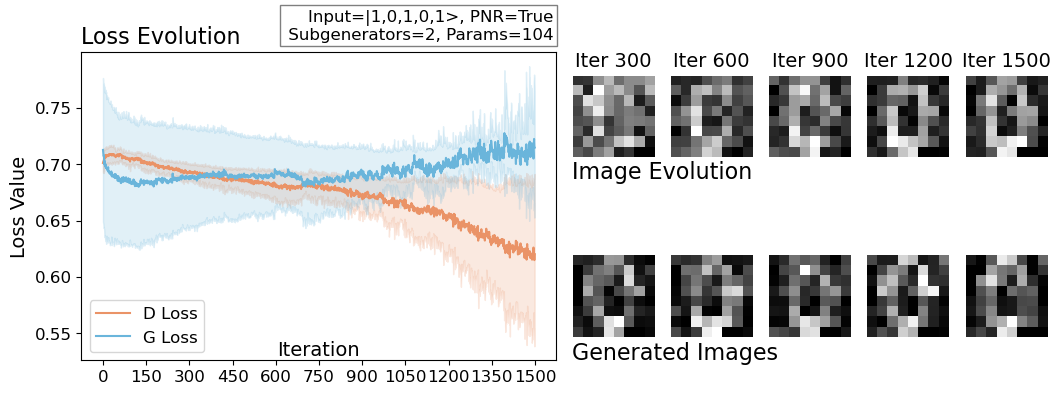

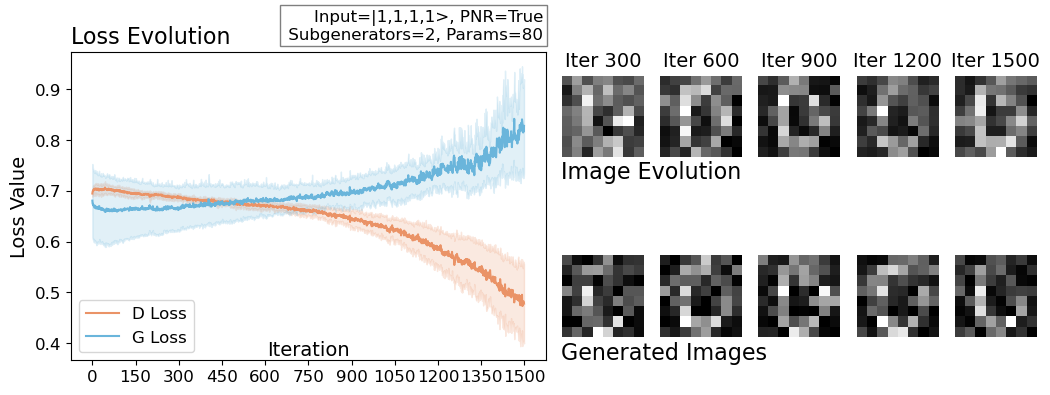

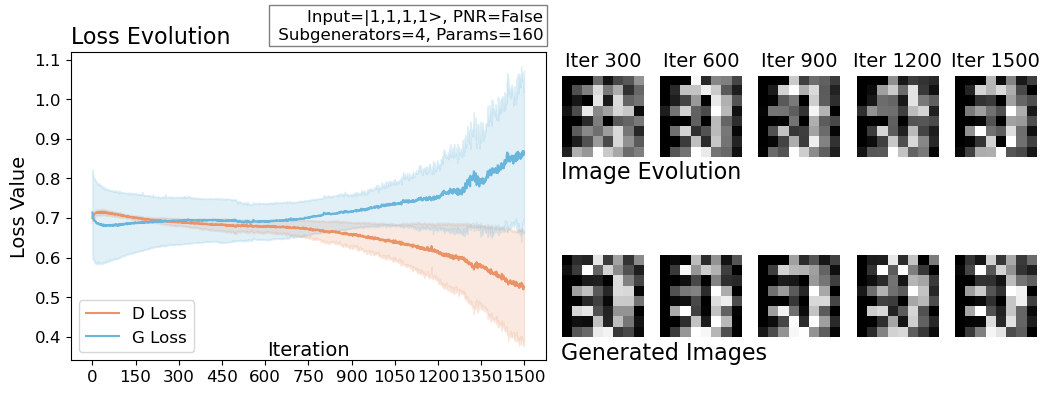

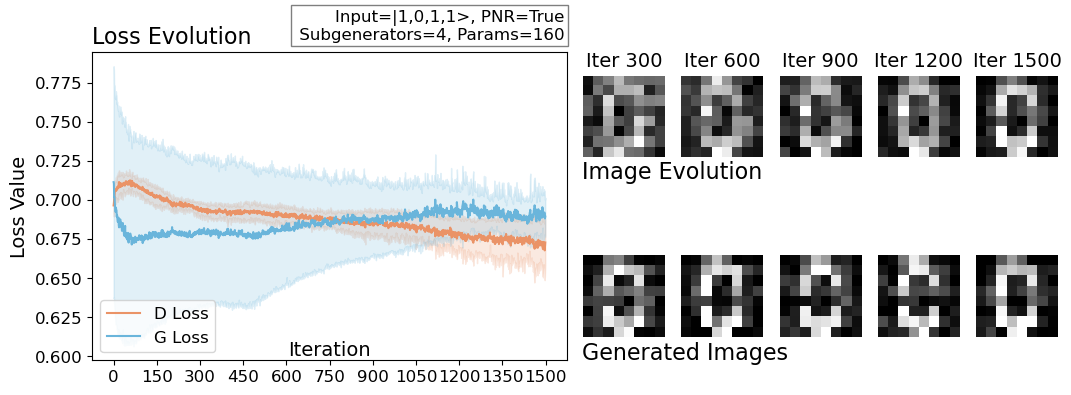

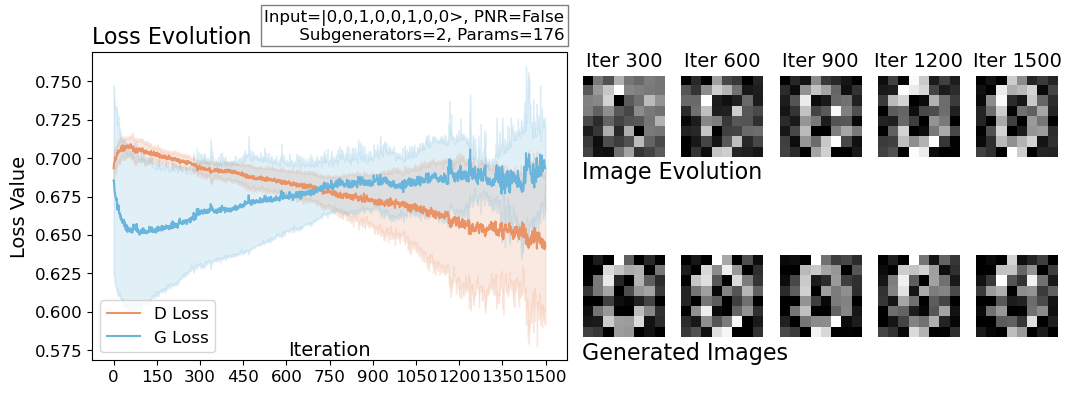

varencvarencvar


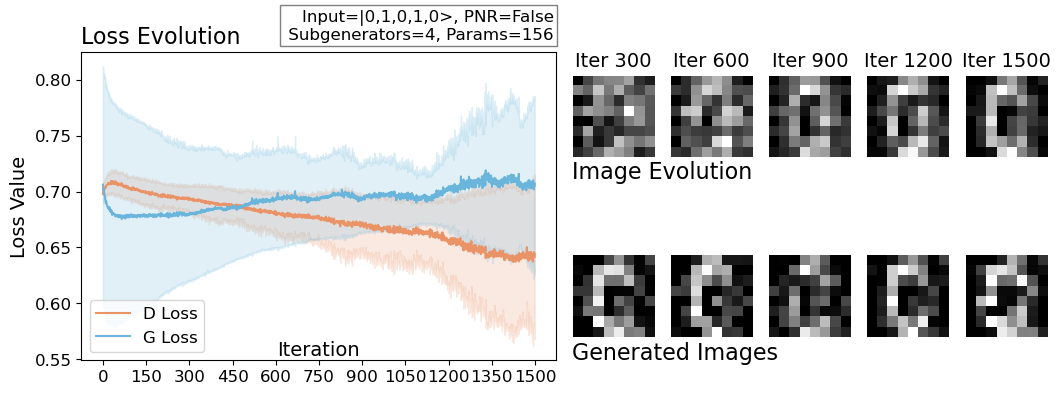

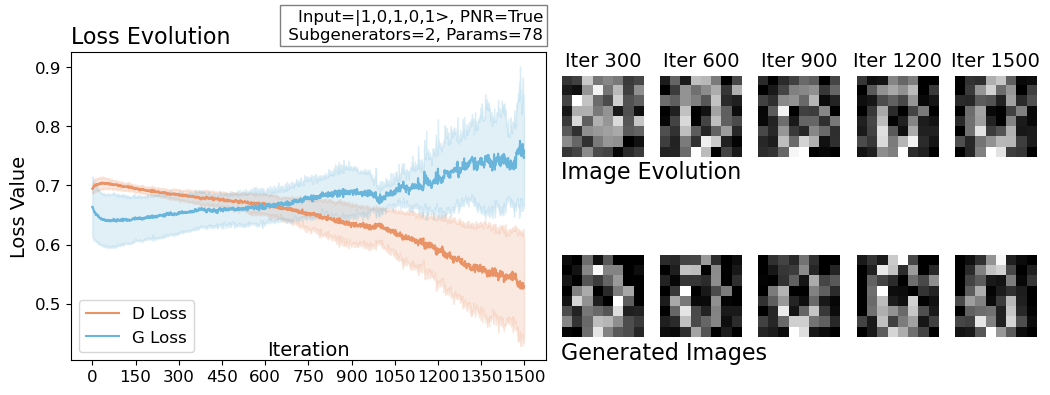

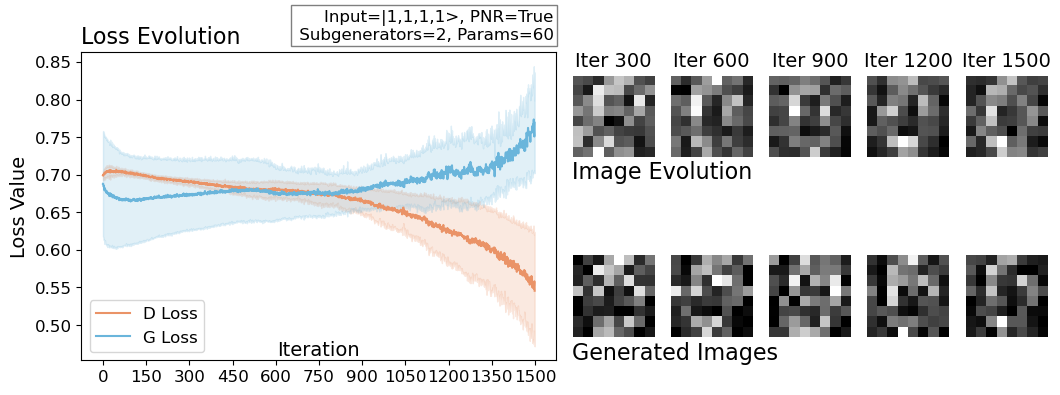

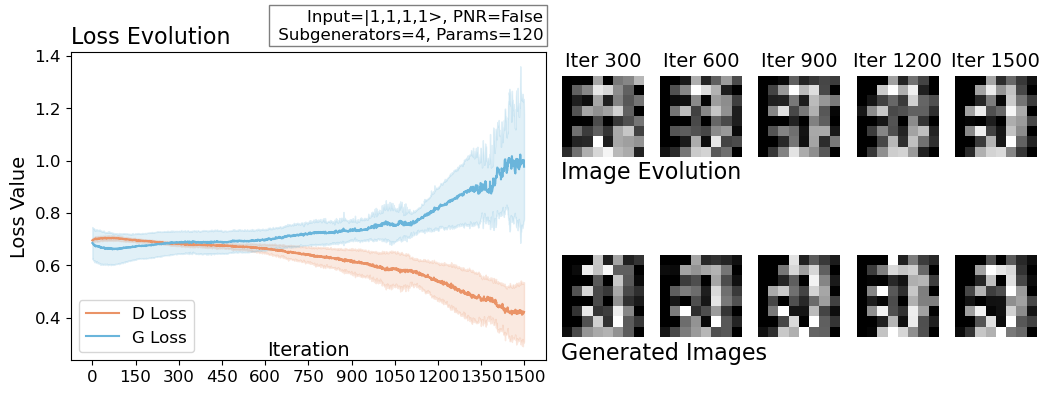

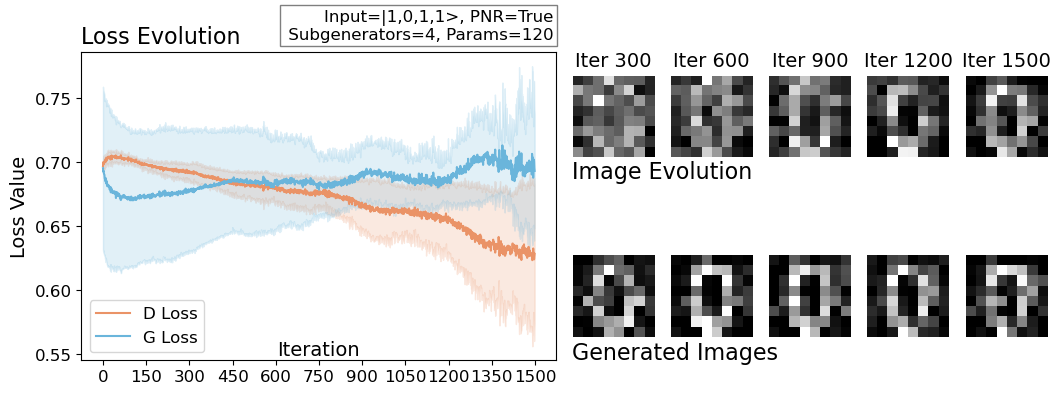

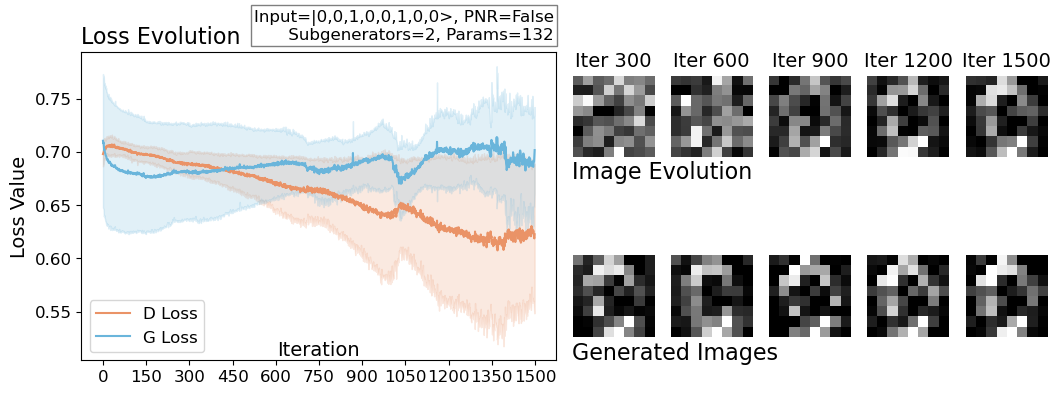

varvarencvarvarencvarvar


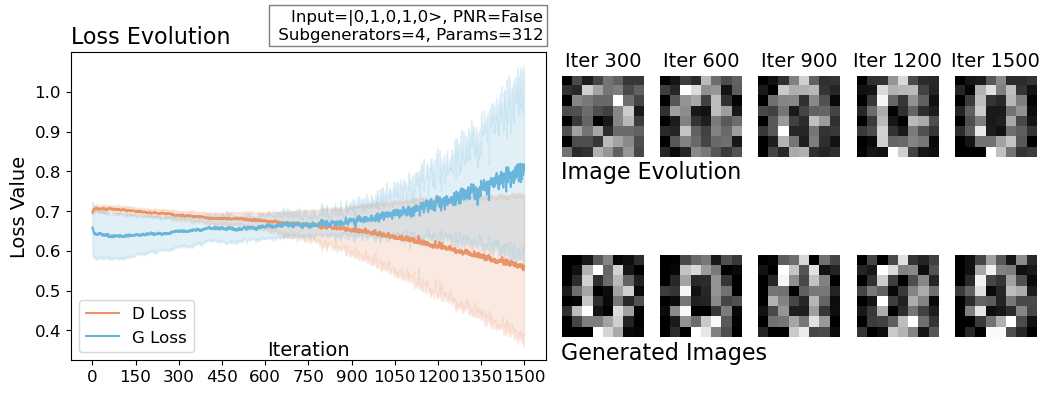

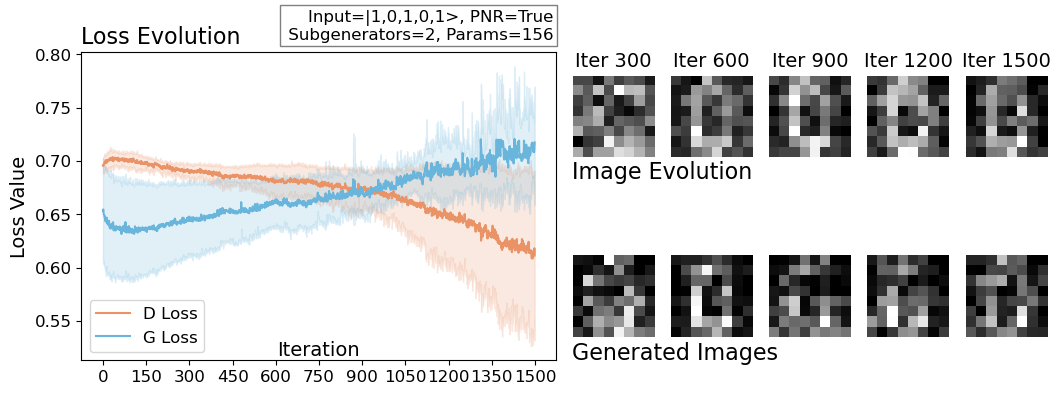

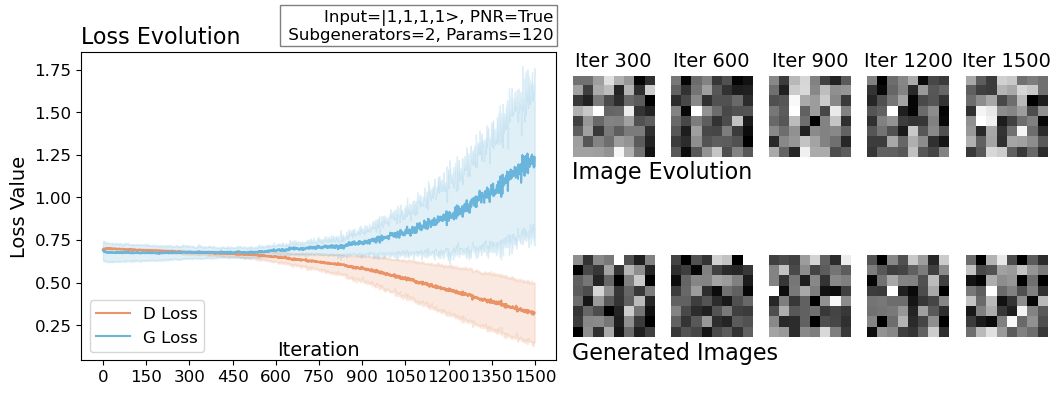

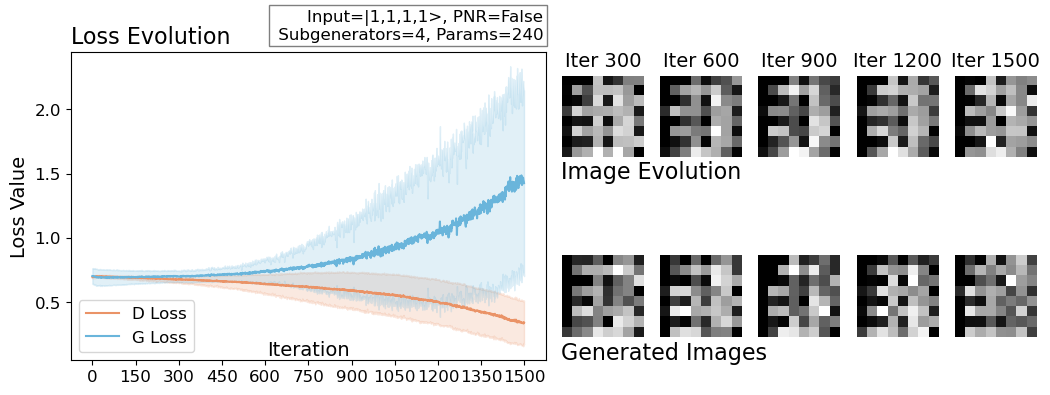

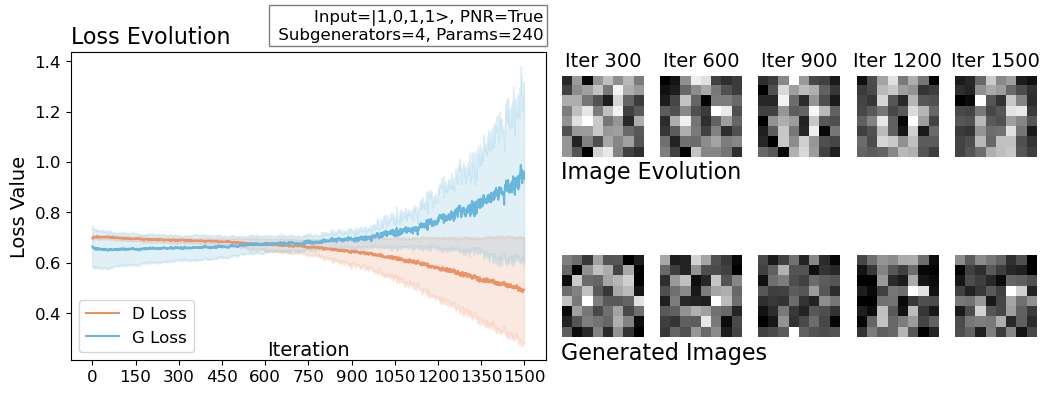

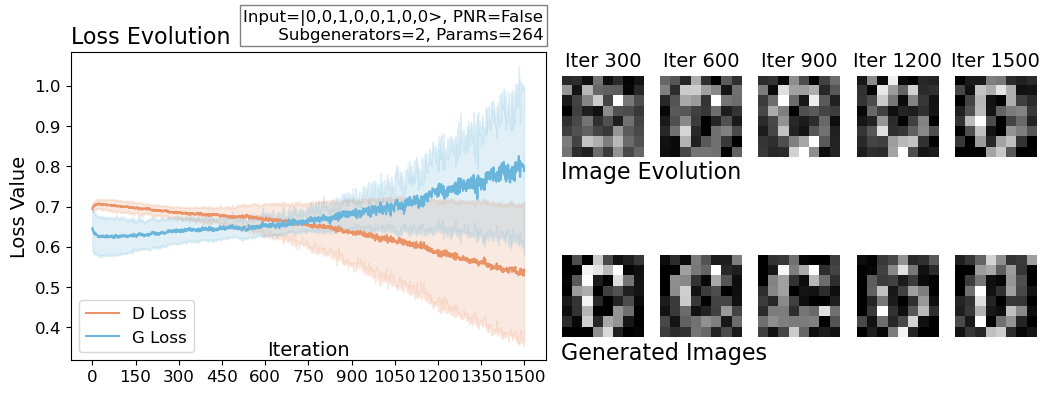

varencvarencvarencvar


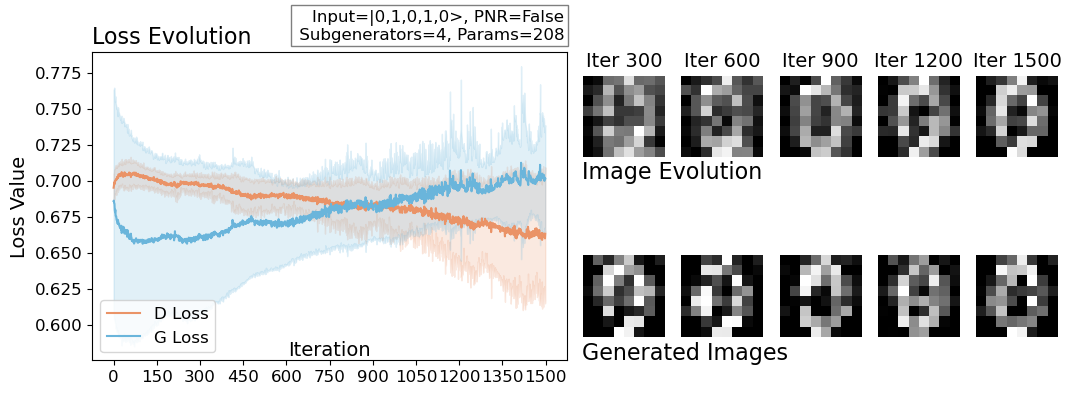

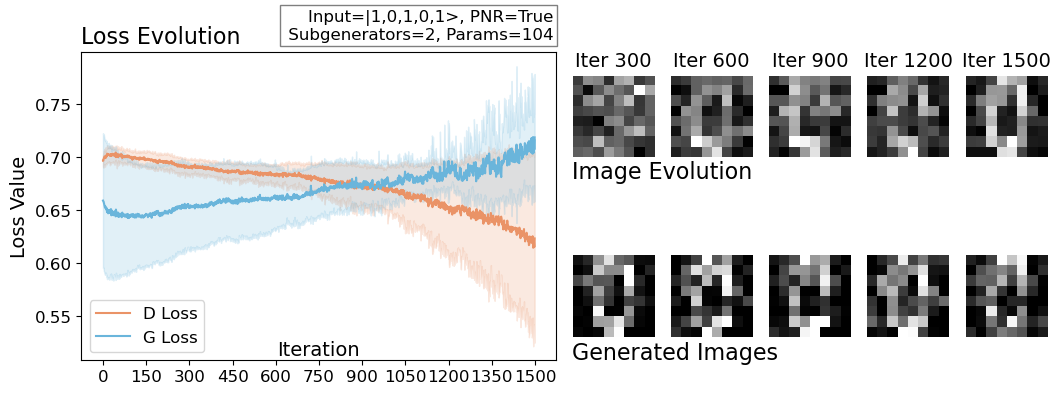

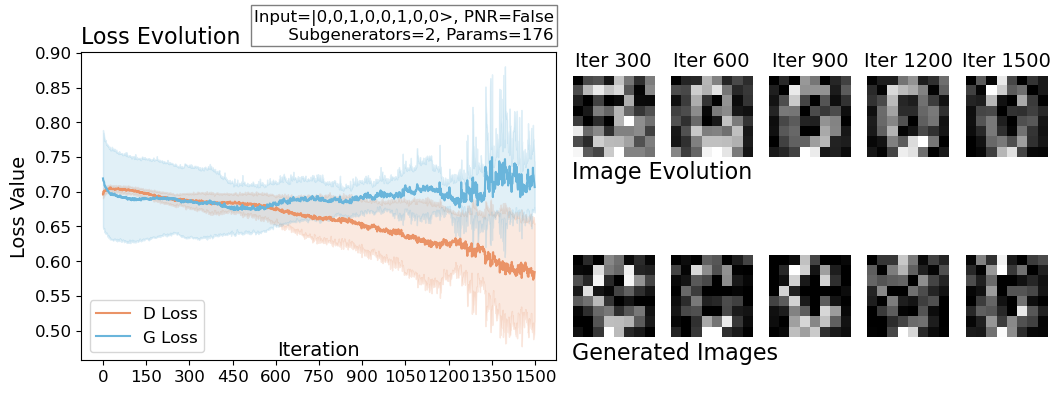

varencvarencvarencvarencvar


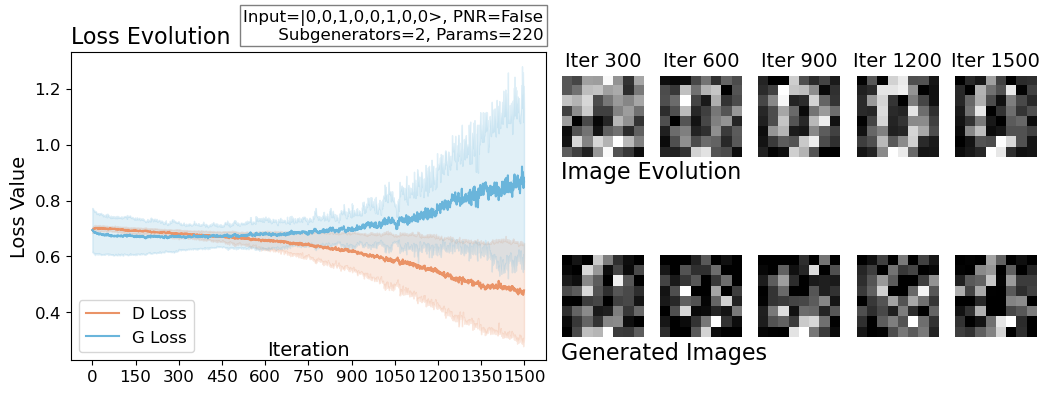

In [8]:
for archstring in archstrings:
    print(archstring)
    for config_num in range(28):
        config_path = path + "config_" + str(config_num)
        with open(config_path + "/config.json") as c:
            config = json.load(c)

        if get_archstring(config["arch"]) != archstring:
            continue
            

        loss_runs = []
        fake_runs = []
        params_runs = []
        for run_num in range(1, 11):
            full_path = path + "config_" + str(config_num) + "/run_" + str(run_num)
            
            loss_runs.append(np.loadtxt(full_path + "/loss_progress.csv", delimiter=","))
            fake_runs.append(np.loadtxt(full_path + "/fake_progress.csv", delimiter=","))
            params_runs.append(np.loadtxt(full_path + "/G_params_progress.csv", delimiter=","))
        
        # best_run = np.argmin(np.abs(np.array(loss_runs)[:, -1, 0] - np.array(loss_runs)[:, -1, 1]))
            
        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(2, 12)
        loss_ax = fig.add_subplot(gs[:, :5])
        prog_axes = [fig.add_subplot(gs[0, 5+i]) for i in range(5)]
        res_axes = [fig.add_subplot(gs[1, 5+i]) for i in range(5)]

        
        plot_loss(np.array(loss_runs), loss_ax)
        plot_progress(np.array(fake_runs), prog_axes)
        plot_results(np.array(params_runs), config, res_axes)
        

        configinfo = "Input=" + str(pcvl.BasicState(config["input_state"])) + ", PNR=" + str(config["pnr"]) + \
                        "\n Subgenerators=" + str(config["gen_count"]) + ", Params=" + str(len(params_runs[0][0])) 
        loss_ax.text(x = 0.995, y = 1.04, s=configinfo, ha="right", bbox = dict(boxstyle='square, pad=0.2',  facecolor='white', alpha=0.5),transform=loss_ax.transAxes, fontdict={"fontsize": 12})

        plt.subplots_adjust(hspace=0.4)
    plt.show()

In [9]:
# fig, ax = plt.subplots()
# ims = []
# for j in range(len(fake_progress[0])):
#     for i in range(len(fake_progress)):
#         im = ax.imshow(fake_progress[i][j].reshape(8, 8), animated=True, cmap="gray")
#         ax.axis("off")
#         # ax.set_title("It " + str(i * 100))
#         ims.append([im])
    
#     ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
#                                     repeat_delay=1000)

#     ani.save("./simulations/im_progress" + str(j) + ".gif")
#     plt.close()

In [10]:
        # counts = []
        # for item in dataloader:
        #     a = torch.logical_and(torch.abs(pil_to_tensor(new_image).reshape(8, 8) / 255 - item[0][0][0]) < 0.004, item[0][0][0] != 0)
        #     counts.append(100.0 * a.sum() / 64)
        # m = np.mean(counts)
        # if m >= 1.0:
        #     print(m)